In [1]:
import time, sys, os
import h5py
import numpy as np
import scipy
from matplotlib.pyplot import *

from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})


In [2]:
import fsps
import sedpy
import prospect
import emcee
import astropy
import math
from astropy.cosmology import WMAP9

In [3]:
from prospect.utils.obsutils import fix_obs
def build_obs(snr=20, ldist=5.3, **extras):
    obs = {}

    galex = ['galex_NUV', 'galex_FUV']
    twomass = ['twomass_{}'.format(b) for b in ['J', 'Ks']]
    sdss = ['sdss_{0}0'.format(b) for b in ['u', 'g','r', 'i']]
    wise = ['wise_w'+n for n in ['1','2', '3', '4']]
    filternames = galex + twomass + sdss + wise
    
    obs["filters"] = sedpy.observate.load_filters(filternames)

    mags = np.array([14.11, 14.63, 9.78, 9.86, 12.57, 11.30, 10.66,
                    10.29, 10.47, 11.02, 9.54, 9.33])
    
    obs["maggies"] = 10**(-0.4*mags)
    obs["maggies_unc"] = (1/snr) * obs["maggies"]
    obs["phot_mask"] = np.array([True for f in obs["filters"]])
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])
    obs["wavelength"] = None
    obs["spectrum"] = None
    obs['unc'] = None
    obs['mask'] = None
    obs = fix_obs(obs)

    return obs

In [4]:
run_params = {}
run_params["snr"] = 20.0
run_params["ldist"] = 5.3
run_params["object_redshift"] = 0.00219
run_params["add_duste"] = True
run_params["fixed_metallicity"] = None

Obs Dictionary Keys:

dict_keys(['filternames', 'maggies_unc', 'phot_wave', 'spectrum', 'mask', 'maggies', 'filters', 'wavelength', 'ndof', 'logify_spectrum', 'phot_mask', 'unc'])

--------
Filter objects:

[<class 'sedpy.observate.Filter'>(galex_NUV), <class 'sedpy.observate.Filter'>(galex_FUV), <class 'sedpy.observate.Filter'>(twomass_J), <class 'sedpy.observate.Filter'>(twomass_Ks), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(wise_w1), <class 'sedpy.observate.Filter'>(wise_w2), <class 'sedpy.observate.Filter'>(wise_w3), <class 'sedpy.observate.Filter'>(wise_w4)]
[7.780e-07 4.565e-06 1.190e-06 ... 6.841e-06 7.396e-06 7.799e-06]
[ 67800.  67900.  68000. ... 199700. 199800. 199900.]


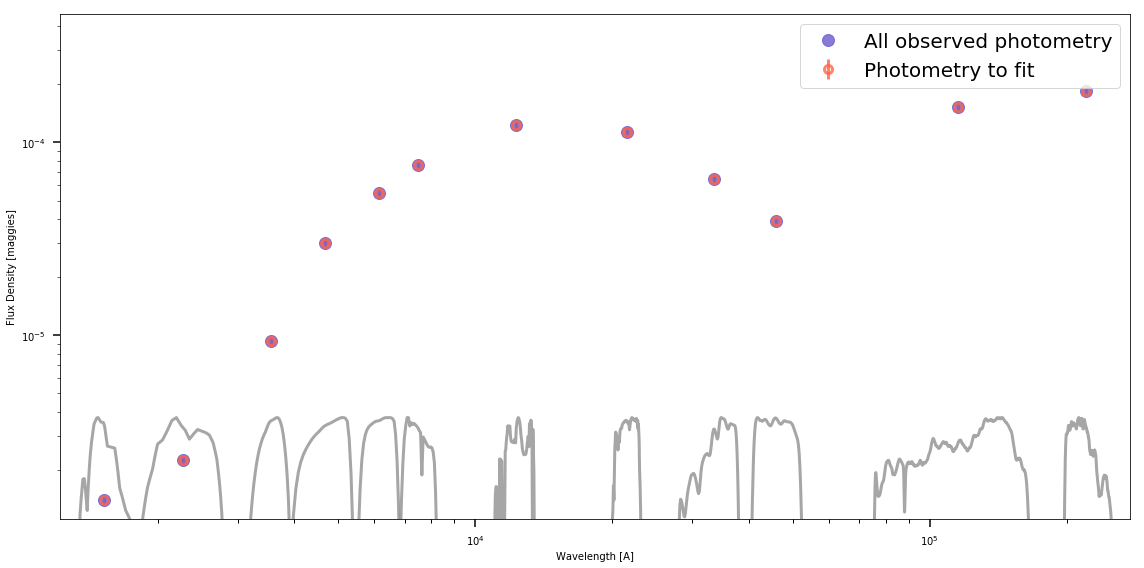

In [5]:
obs = build_obs(**run_params)

# Look at the contents of the obs dictionary
print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
print("--------\nFilter objects:\n")
print(obs["filters"])
#print(obs['phot_mask'])
# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
figure(figsize=(16,8))

# plot all the data
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# overplot only the data we intend to fit
mask = obs["phot_mask"]
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
print(obs['filters'][-2].transmission)
print(obs['filters'][-2].wavelength)
# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
tight_layout()

In [6]:
from prospect.models.templates import TemplateLibrary
TemplateLibrary.describe('continuity_sfh')

Free Parameters: (name: prior) 
-----------
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(scale=[0.3 0.3],mean=[0. 0.],df=[2 2])
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  logmass: <class 'prospect.models.priors.TopHat'>(mini=7,maxi=12)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.1 
  dust_type: 0 
  imf_type: 2 
  agebins: [[0.0, 8.0], [8.0, 9.0], [9.0, 10.0]] 
  sfh: 3 
  mass: 1000000.0 <function logsfr_ratios_to_masses at 0x7ff1c296f9d8>


In [32]:
def build_model(object_redshift=None, ldist=5.3, fixed_metallicity = None, add_duste = False, 
                **extras):
    
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary, adjust_continuity_agebins
    from prospect.models import priors

    model_params = TemplateLibrary["continuity_sfh"]
    model_params.update(TemplateLibrary["dust_emission"])
    
    model_params["duste_qpah"]["isfree"] = True
    model_params["duste_umin"]['isfree'] = True
    model_params["duste_gamma"]["isfree"] = True
    
    model_params["zred"]["init"] = 0.0
    model_params["logmass"]["init"] = 10.2
    model_params["mass"]["init"] = 1e8
    model_params["logsfr_ratios"]["init"] = [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
    model_params["agebins"]["init"] = [0.0, 8.0], [8.0, 9.0], [9.0, 10.0]
    model_params["dust2"]["init"] = 0.20
    model_params["logzsol"]["init"] = -0.50
    model_params["dust_type"]["init"] = 2
    
    model_params["logmass"]["prior"] = priors.TopHat(mini=7, maxi=12)
    model_params["logsfr_ratios"]["priors"] = priors.StudentT(mean=np.full(7,0),scale=np.full(7,0.3),df= np.full(7,2))
    model_params["duste_qpah"]["prior"] = priors.TopHat(mini=0, maxi=10)
    model_params["duste_umin"]["prior"] = priors.TopHat(mini=1e-1, maxi=25)
    model_params["duste_gamma"]["prior"] = priors.TopHat(mini=0, maxi=1.0)
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2)
    model_params["logzsol"]["prior"] = priors.TopHat(mini= -2, maxi = 0.19)

    model_params["logmass"]["disp_floor"] = 0.1
    model_params["dust2"]["disp_floor"] = 0.1
    model_params["duste_gamma"]["disp_floor"] = 0.3
    model_params["duste_qpah"]["disp_floor"] = 3
    model_params["duste_umin"]["disp_floor"] = 5
    

    if fixed_metallicity is not None:
        model_params["logzsol"]["isfree"] = False
        model_params["logzsol"]['init'] = fixed_metallicity 

    if object_redshift is not None:
        model_params["zred"]['isfree'] = False
        model_params["zred"]['init'] = object_redshift

    model_params["sfh"]["init"] = 0
    
    
    model_params=adjust_continuity_agebins(model_params, tuniv=13.7459, nbins=8)
    agebins=model_params["agebins"]["init"]
    model = SedModel(model_params)
    
    return model

#run_params["object_redshift"] = 0.003
#run_params["fixed_metallicity"] = 0.5
#run_params["add_neb"] = False
    


In [33]:
model = build_model(**run_params)
print(model)    
print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
print("Initial parameter dictionary:\n{}".format(model.params))

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(scale=[0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3],mean=[0. 0. 0. 0. 0. 0. 0. 0. 0.],df=[2. 2. 2. 2. 2. 2. 2. 2. 2.])
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  duste_gamma: <class 'prospect.models.priors.TopHat'>(mini=0,maxi=1.0)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2)
  logmass: <class 'prospect.models.priors.TopHat'>(mini=7,maxi=12)
  duste_qpah: <class 'prospect.models.priors.TopHat'>(mini=0,maxi=10)
  duste_umin: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=25)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  dust_type: 2 
  agebins: [[ 0.          7.4772    ]
 [ 7.4772      8.        ]
 [ 8.          8.2953703 ]
 [ 8.2953703   8.5907406 ]
 [ 8.5907406   8.8861109 ]
 [ 8.8861109   9.1814812 ]
 [ 9.1814812   9.4768515 ]
 [ 9.4768515   9.77222181]
 [ 9.7722218

In [34]:
def build_sps(zcontinuous=1, **extras):
    """
    :param zcontinuous: 
        A vlue of 1 insures that we use interpolation between SSPs to 
        have a continuous metallicity parameter (`logzsol`)
        See python-FSPS documentation for details
    """
    from prospect.sources import FastStepBasis
    sps = FastStepBasis(zcontinuous=zcontinuous)
    return sps

run_params["zcontinuous"] = 1

In [35]:
sps = build_sps(**run_params)

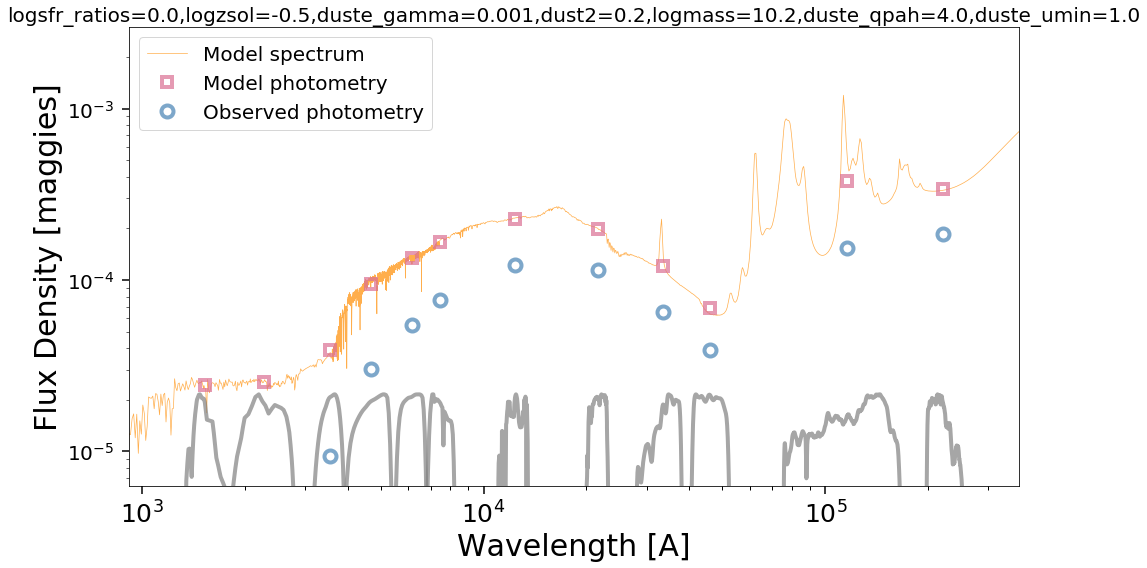

In [36]:
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.6, np.max(wphot)/0.6
temp = np.interp(np.linspace(xmin,xmax,8000), wspec, initial_spec)
ymin, ymax = temp.min()*0.5, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='darkorange', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.7, ls='', lw=4,
         markerfacecolor='none', markeredgecolor='palevioletred', 
         markeredgewidth=4)
errorbar(wphot, obs['maggies'], 
         label='Observed photometry',
         marker='o', markersize=12, alpha=0.7, ls='', lw=4,
         ecolor='steelblue', markerfacecolor='none', markeredgecolor='steelblue', 
         markeredgewidth=4)
title(title_text, fontsize = 20)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=4, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]', fontsize = 30)
ylabel('Flux Density [maggies]', fontsize = 30)
xlim([xmin, xmax])
ylim([ymin, ymax])
matplotlib.rc('xtick', labelsize=25)
matplotlib.rc('ytick', labelsize=20) 
legend(loc='best', fontsize=20)
tight_layout()

In [37]:
from prospect.fitting import lnprobfn
help(lnprobfn)

Help on function lnprobfn in module prospect.fitting.fitting:

lnprobfn(theta, model=None, obs=None, sps=None, noise=(None, None), residuals=False, nested=False, verbose=False)
    Given a parameter vector and optionally a dictionary of observational
    ata and a model object, return the ln of the posterior. This requires that
    an sps object (and if using spectra and gaussian processes, a GP object) be
    instantiated.
    
    :param theta:
        Input parameter vector, ndarray of shape (ndim,)
    
    :param model:
        SedModel model object, with attributes including ``params``, a
        dictionary of model parameter state.  It must also have
        :py:method:`prior_product`, and :py:method:`mean_model` methods
        defined.
    
    :param obs:
        A dictionary of observational data.  The keys should be
          *``wavelength``  (angstroms)
          *``spectrum``    (maggies)
          *``unc``         (maggies)
          *``maggies``     (photometry in maggi

In [38]:
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)
print(sps.ssp.libraries)

(b'mist', b'miles')


In [39]:
from prospect.fitting import fit_model

In [41]:
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# the first based on the current values of each parameter and the 
# rest drawn from the prior.  Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 4

output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)

print(model.theta_labels())
print("Done optmization in {}s".format(output["optimization"][1]))

minimizer: Exception while trying to minimize the function:
  params: [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00 -5.00e-01  1.00e-03  2.00e-01  1.02e+01  4.00e+00
  1.00e+00]
  args: ()
  exception:


Traceback (most recent call last):
  File "/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/fitting/minimizer.py", line 23, in __call__
    method=self.meth, **self.opts)
  File "/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/scipy/optimize/_lsq/least_squares.py", line 811, in least_squares
    raise ValueError("Method 'lm' doesn't work when the number of "
ValueError: Method 'lm' doesn't work when the number of residuals is less than the number of variables.


ValueError: Method 'lm' doesn't work when the number of residuals is less than the number of variables.

[ 1.00001649e-01  2.88821535e-03  3.63090691e-01  9.06914644e+00
  9.82643404e+00 -7.35578205e-01 -1.03972151e-01 -7.97544366e-02
 -6.35523096e-02 -4.71694508e-02 -2.46286507e-02  1.08508231e-03
  1.34040277e-01]
0
-45551.238687257704
[ 1.00001649e-01  2.88821535e-03  3.63090691e-01  1.00000000e+01
  9.82643404e+00 -7.35578205e-01 -1.03972151e-01 -7.97544366e-02
 -6.35523096e-02 -4.71694508e-02 -2.46286507e-02  1.08508231e-03
  1.34040277e-01]
['duste_umin', 'duste_gamma', 'dust2', 'logmass', 'duste_qpah', 'logzsol', 'logsfr_ratios_1', 'logsfr_ratios_2', 'logsfr_ratios_3', 'logsfr_ratios_4', 'logsfr_ratios_5', 'logsfr_ratios_6', 'logsfr_ratios_7']
[ 68.80019109 198.15178094 -16.32688053 -16.62932656 -16.80863524
  -4.92840768 -12.2495755  -14.60074812 -15.4054607  -15.51479821
 -14.83023494 141.76890862 159.36853156]


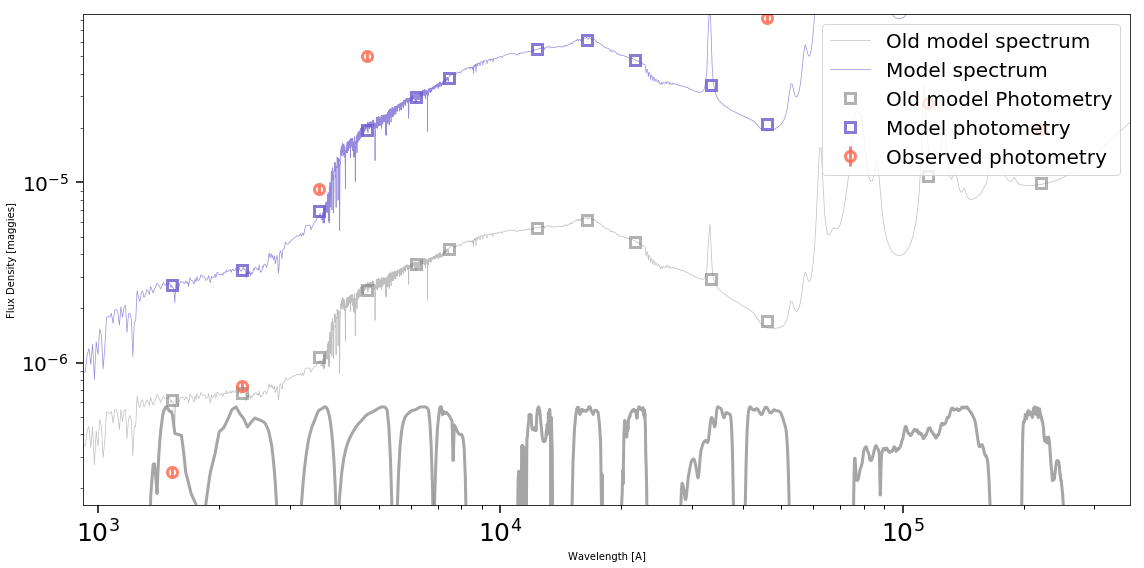

In [44]:
print(model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print(ind_best)
theta_best = results[ind_best].x.copy()
theta_best[3] = 10
maxprob =  lnprobfn(theta_best, model=model, obs=obs, sps=sps)
print(maxprob)
print(theta_best)

# generate model
prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

figure(figsize=(16,8))

# plot Data, best fit model, and old models
loglog(wspec, initial_spec, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
loglog(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7)
errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='slateblue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()
print(model.theta_labels())
print((pphot-obs["maggies"])/obs["maggies_unc"])

In [42]:
run_params["optimize"] = False
run_params["emcee"] = True
run_params["dynesty"] = False
# Number of emcee walkers
run_params["nwalkers"] = 30
# Number of iterations of the MCMC sampling
run_params["niter"] = 2000
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
run_params["nburn"] = [16, 32, 64]

In [43]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done emcee in {0}s'.format(output["sampling"][1]))

number of walkers=30


/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/models/priors.py:90: RuntimeWarning: divide by zero encountered in log


done burn #0 (16 iterations)
done burn #1 (32 iterations)
done burn #2 (64 iterations)
number of walkers=30
starting production
done production
done emcee in 983.2057173252106s


In [44]:
import prospect.io.write_results as writer
hfile = "NGC0628_mcmc.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])
print('Finished')

Finished


/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:52: RuntimeWarning: Could not store paramfile text
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:225: RuntimeWarning: Could not JSON serialize model_params, pickled instead
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:254: UserWarning: Could not JSON serialize ndof, pickled instead


MAP value: [-1.94532578e-01 -7.91162987e-02 -1.26272464e-01 -2.26419923e-01
 -2.05651500e-01 -3.32840400e-02 -1.48797368e-01 -2.64532370e-02
  6.96030907e-02 -5.49157612e-01  1.06438686e-02  4.32087962e-01
  1.00694564e+01  4.63211830e+00  1.48184464e+01]


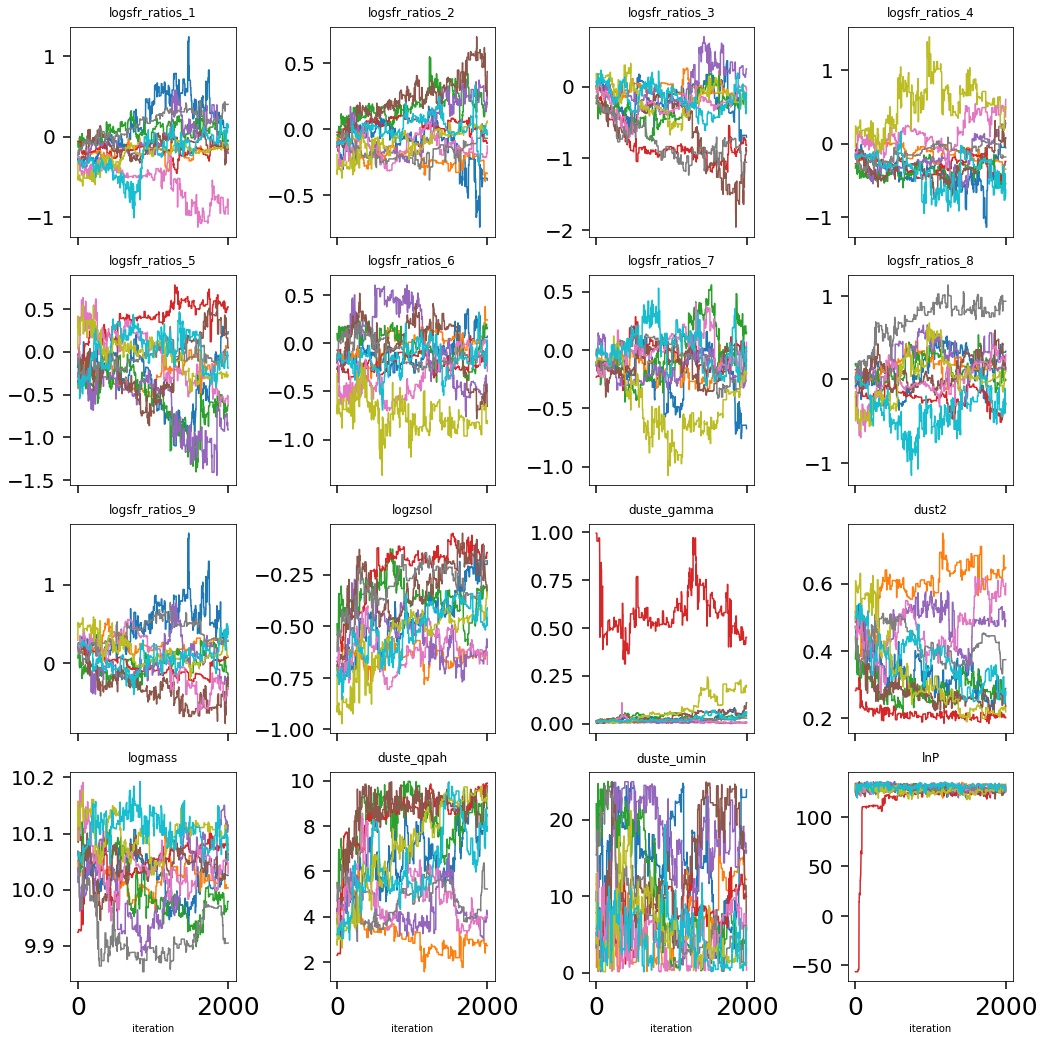

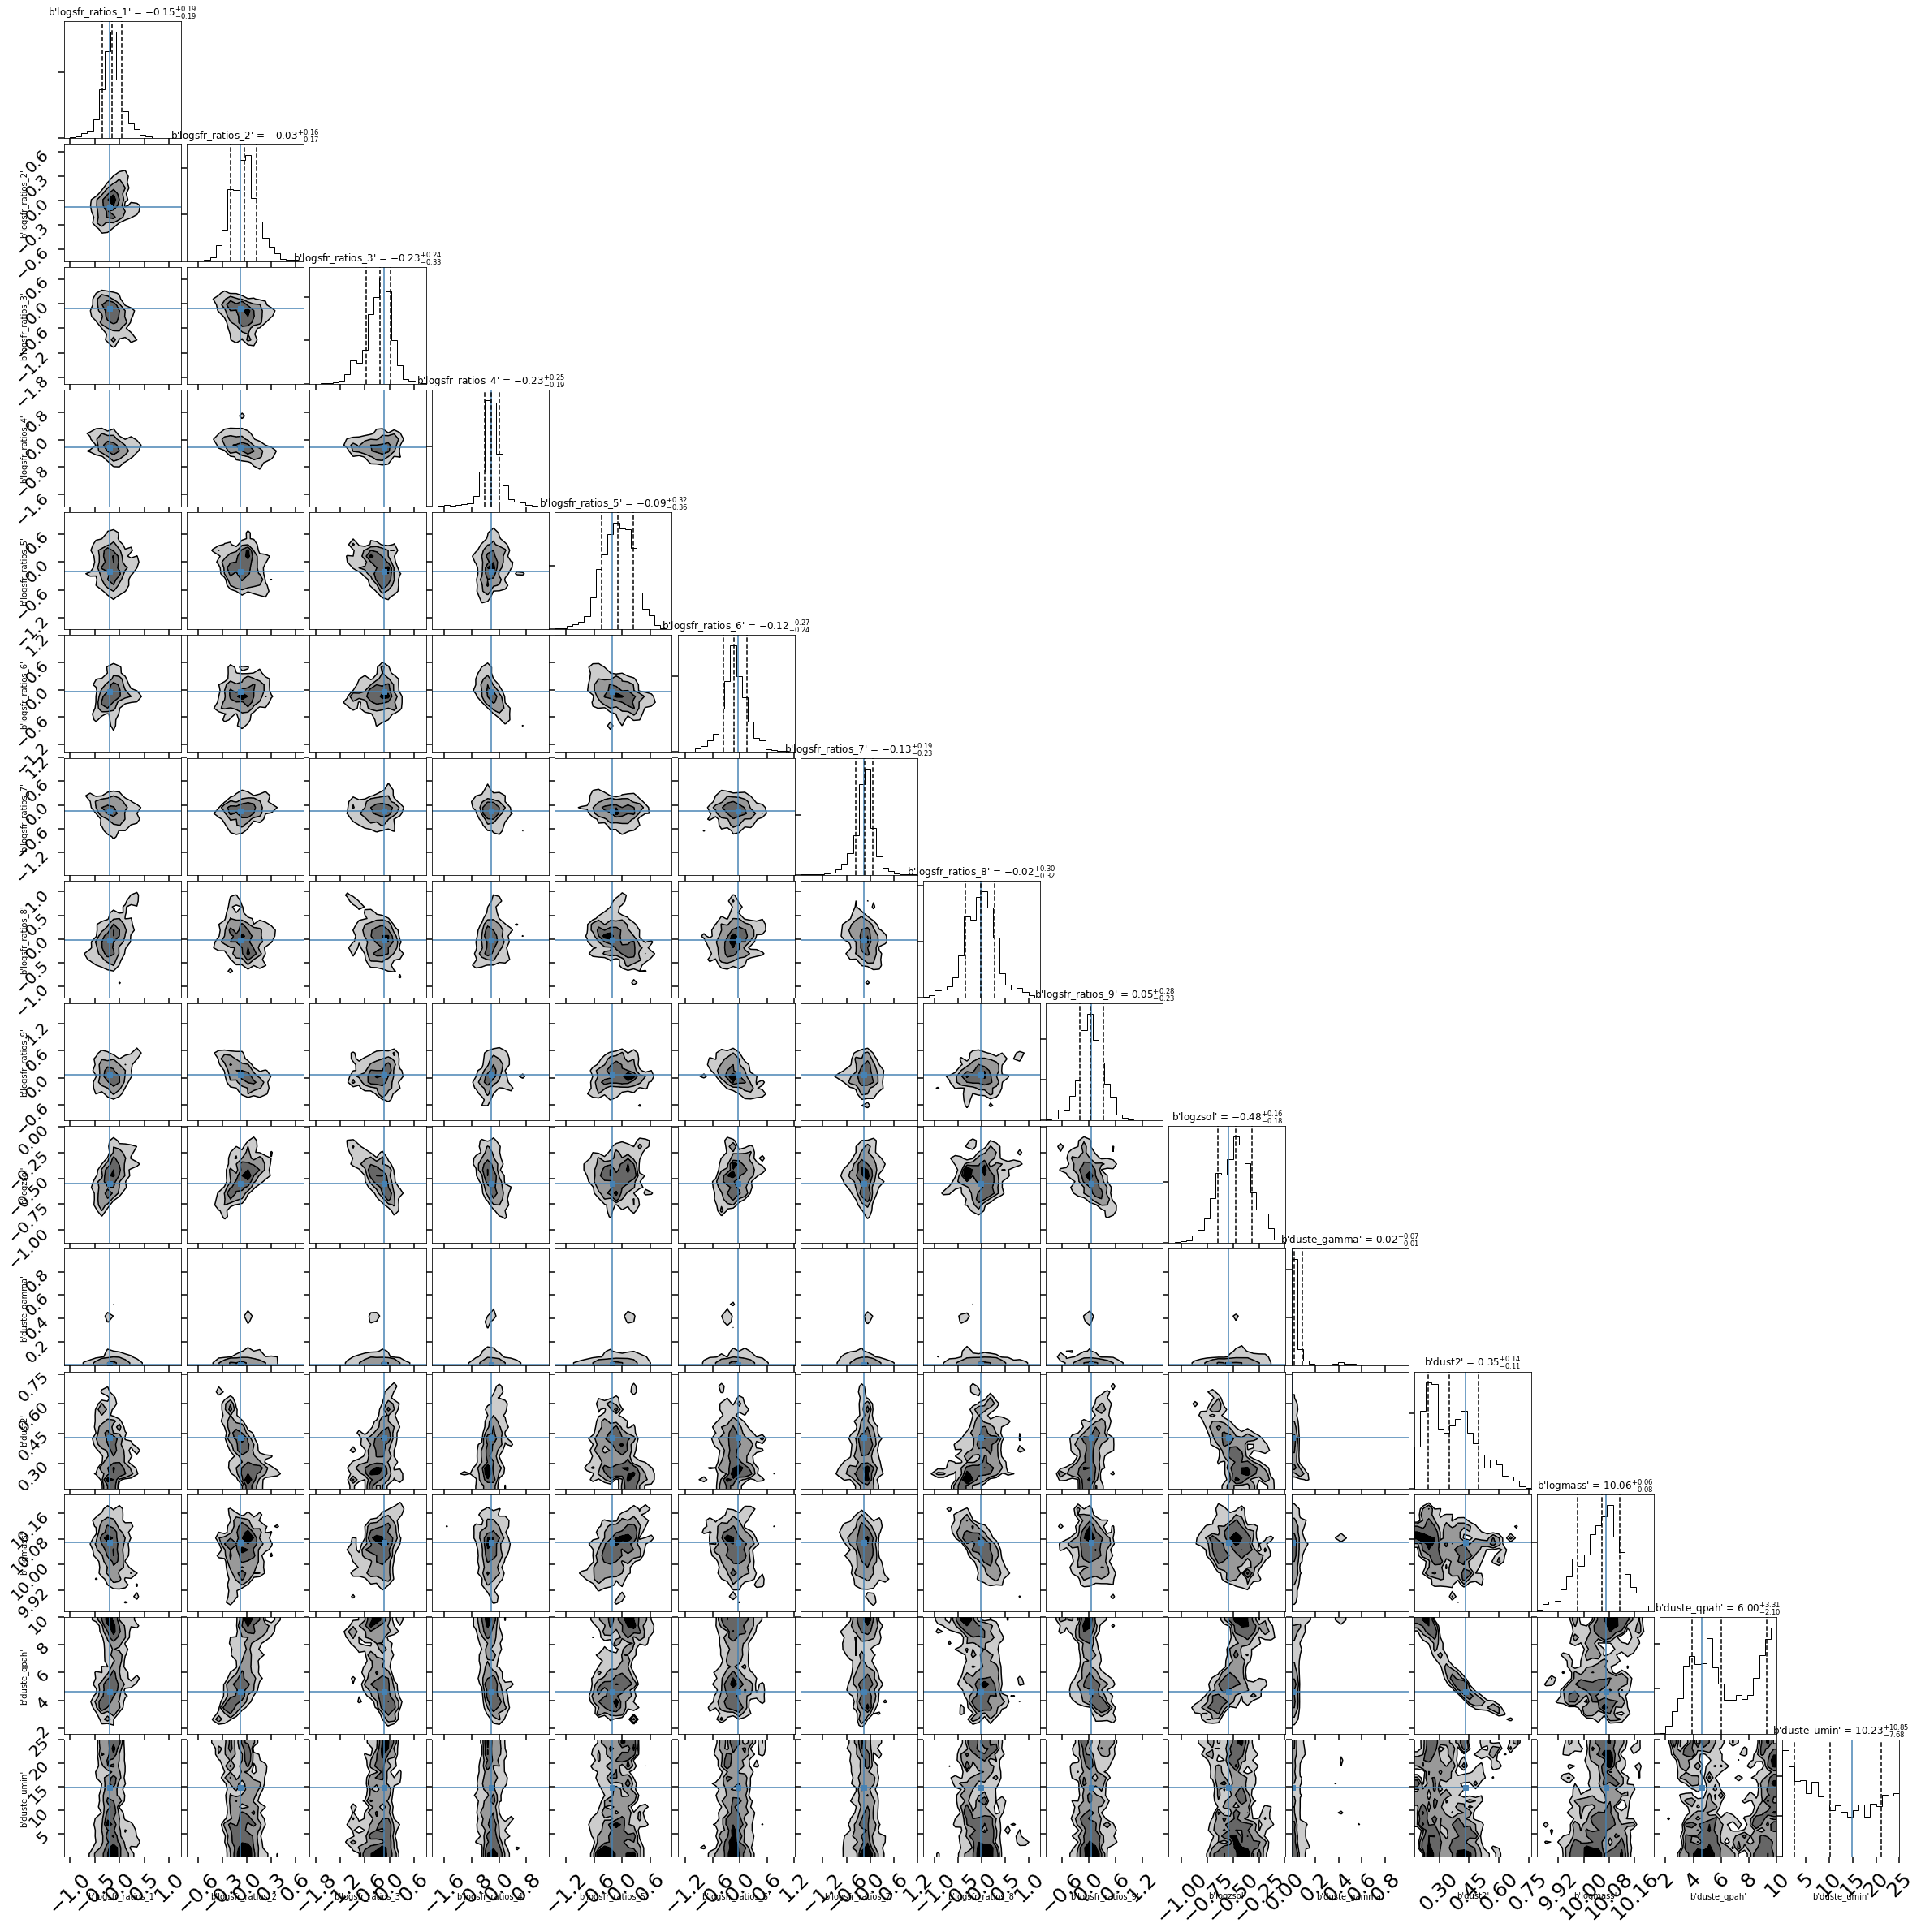

In [45]:
(res, topt) = output["sampling"]
import prospect.io.read_results as reader
res, obs, model = reader.results_from("NGC0628_mcmc.h5")
ind_max = res["lnprobability"].argmax()
chosen = np.random.choice(res["run_params"]["nwalkers"], size=10, replace=False)
walker, iteration = np.unravel_index(ind_max, res["lnprobability"].shape)
theta_max = res["chain"][walker, iteration, :]
tracefig = reader.traceplot(res, chains = chosen)
thin = 1
#cornerfig = reader.subcorner(res, , thin=thin)
cornerfig = reader.subcorner(res, thin=thin, truths=theta_max)
print('MAP value: {}'.format(theta_max))

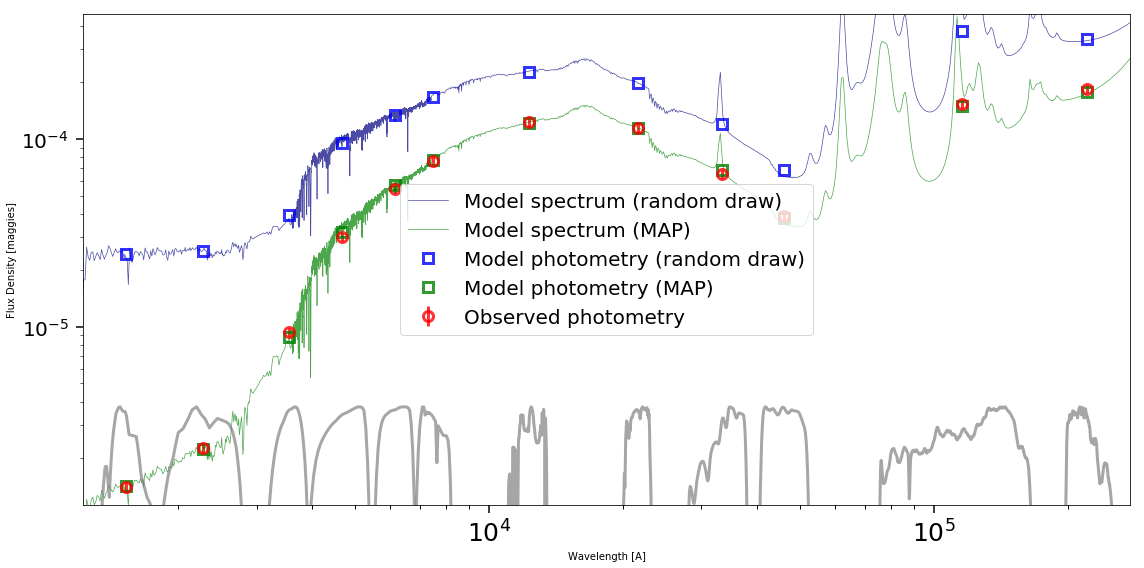

In [46]:
from matplotlib.pyplot import *
randint = np.random.randint
res_type = "emcee"
if res_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = res['chain'][randint(nwalkers), randint(niter)]

obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)
theta = model.theta.copy()
wspec = sps.wavelengths
wphot = obs["phot_wave"]
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

figure(figsize=(16,8))

xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4


loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

#plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()


In [13]:
#SFH PLOT ATTEMPT
ind_max = res["lnprobability"].argmax()
ind_max = res["lnprobability"].argmax()
chosen = np.random.choice(res["run_params"]["nwalkers"], size=256, replace=False)
#for i in res.keys():
    #print(i)
#for s in res["obs"]:

#print(res["chain"])
print(res["theta_labels"])
#the samples of logsfr_ratios_2 only 256 bc the walkers are 256
#need indices: 1,2,3,4,5,6,7
print(res["chain"][:,-1,3])



['dust2', 'logsfr_ratios_1', 'logsfr_ratios_2', 'logsfr_ratios_3', 'logsfr_ratios_4', 'logsfr_ratios_5', 'logsfr_ratios_6', 'logsfr_ratios_7', 'logzsol', 'duste_qpah', 'logmass']
[ 3.99833255e-01 -6.43688667e-02  2.65897657e-01  1.60384220e+00
  9.01491529e-02 -6.68453640e-03  8.47780450e-02 -3.66822093e-01
  9.29212655e-02  4.84649057e-01  8.22120342e-01 -1.86004414e-01
  6.73873797e-01  6.38907336e-02  1.22334793e+00  6.11254758e-01
  1.34158557e-01 -2.05482715e-01  1.81442742e-01  2.23061980e-02
 -4.89236913e-01  1.33539103e-01  5.55341580e-01 -2.55283601e-01
  7.25434523e-01  1.98781858e-01  5.51746704e-02 -6.27162209e-02
 -1.10349131e-01 -7.35432097e-01  7.69005360e-01 -1.71156428e-01
  1.98924606e+00  7.27475601e-01  5.71426951e-02 -1.13930308e-01
  5.63956925e-01  5.26546472e-02  7.54879704e-01  9.91253997e-01
  2.75772609e-01  1.83560387e+00  5.03865441e-01  1.29469732e-02
  6.71209486e-02 -4.07703247e-01  6.92959990e-01  2.15657789e-01
 -5.95630783e-01  5.65306284e-03 -7.39452

In [215]:
from prospect.models import transforms
agebins = [0.,7.4772 ], [7.4772,8.], [ 8.,8.49641892], 
[ 8.49641892:8.99283783], [8.99283783:9.48925675], 
[ 9.48925675:9.98567566],
[9.98567566:10.05625674]
logsfr_ratios_to_masses (logmass=res["chain"][:,-1,1], 
                        logsfr_ratios=res["chain"][:,-1,3], 
                        agebins=agebins)

SyntaxError: invalid syntax (<ipython-input-215-3fc0ef7f7a0a>, line 3)